# Import các thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim


# Import dữ liệu và tiền xử lý

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DIG Historical Data 1_6.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [3]:
df1=df.reset_index()['Price']
df1.head()

0    11033.2
1    11457.6
2    12094.1
3    12094.1
4    12200.2
Name: Price, dtype: float64

In [4]:
df1

0       11033.2
1       11457.6
2       12094.1
3       12094.1
4       12200.2
         ...   
1593    27350.0
1594    27850.0
1595    27950.0
1596    27600.0
1597    27750.0
Name: Price, Length: 1598, dtype: float64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
test_size

479

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
X_train.shape

(1017, 100)

# Tạo Dataset cho PyTorch
Để có thể áp dụng vào model ResNet


In [11]:
# Tạo Dataset cho PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Mô hình ResNET

In [12]:
# Định nghĩa mô hình ResNet
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNet(Module):
    def __init__(self, c_in, c_out, nf=64, kss=[7, 5, 3]):
        super().__init__()
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.global_avg_pool(x).squeeze(-1)  # Global Average Pooling to (batch, channels)
        x = self.fc(x)
        return x

In [13]:
# Khởi tạo mô hình
model = ResNet(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.006462413351982832, Test Loss: 0.005964564295330395
Epoch 2/100, Loss: 0.004417823627591133, Test Loss: 0.005869631616709133
Epoch 3/100, Loss: 0.002531098434701562, Test Loss: 0.007645337454353769
Epoch 4/100, Loss: 0.0028946748934686184, Test Loss: 0.006085242901463062
Epoch 5/100, Loss: 0.001202641986310482, Test Loss: 0.004852130795673777
Epoch 6/100, Loss: 0.012811414897441864, Test Loss: 0.0088711034914013
Epoch 7/100, Loss: 0.014856956899166107, Test Loss: 0.010570772331751263
Epoch 8/100, Loss: 0.0064479513093829155, Test Loss: 0.0072262604323138175
Epoch 9/100, Loss: 0.007512273266911507, Test Loss: 0.006233771603244047
Epoch 10/100, Loss: 0.005840849131345749, Test Loss: 0.00584387260338796
Epoch 11/100, Loss: 0.004336838610470295, Test Loss: 0.004224906209856272
Epoch 12/100, Loss: 0.003934042062610388, Test Loss: 0.004196354459660749
Epoch 13/100, Loss: 0.007279976736754179, Test Loss: 0.004856801797965697
Epoch 14/100, Loss: 0.0025064789224416018, Test

# Predict

In [15]:
# Dự báo dữ liệu test
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [16]:
# Dự báo 30 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

In [17]:
# Dự báo 60 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [18]:
# Dự báo 90 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

# Các độ đo

In [19]:
# Các độ đo
import numpy as np

# Mean Absolute Error
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Root Mean Squared Error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Mean Absolute Scaled Error
def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors / d)


In [20]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 1970.8761
Test MAPE: 10.6131%
Test MASE: 277347.0245
Test MSE: 5670912.4281
Test RMSE: 2381.3678


# Vẽ hình

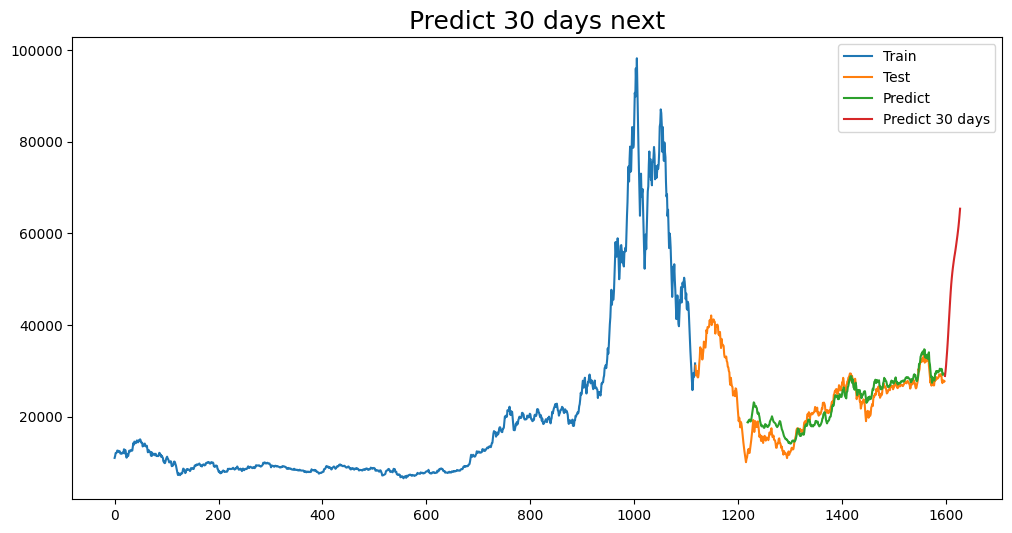

In [21]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 30 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

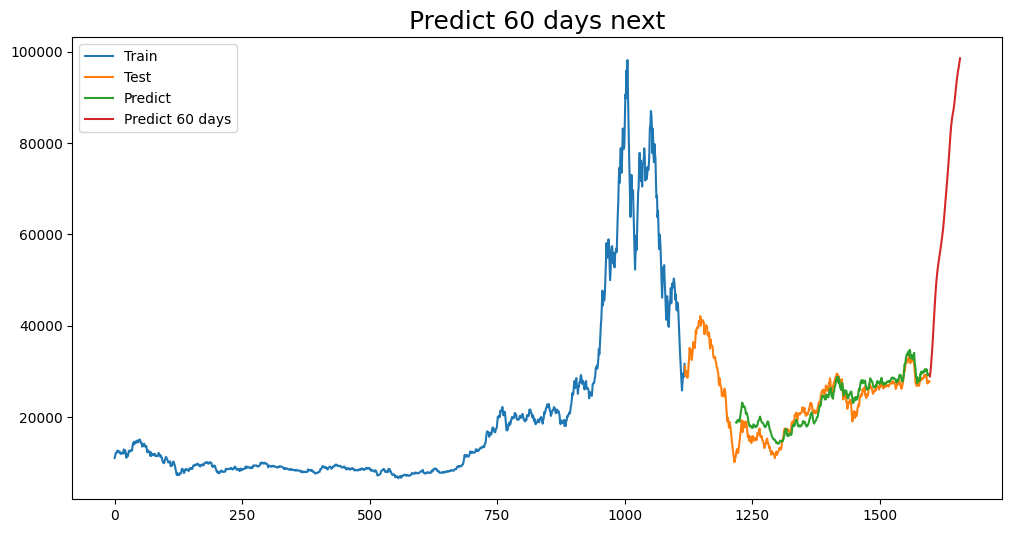

In [22]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 60 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')

plt.legend()
plt.show()

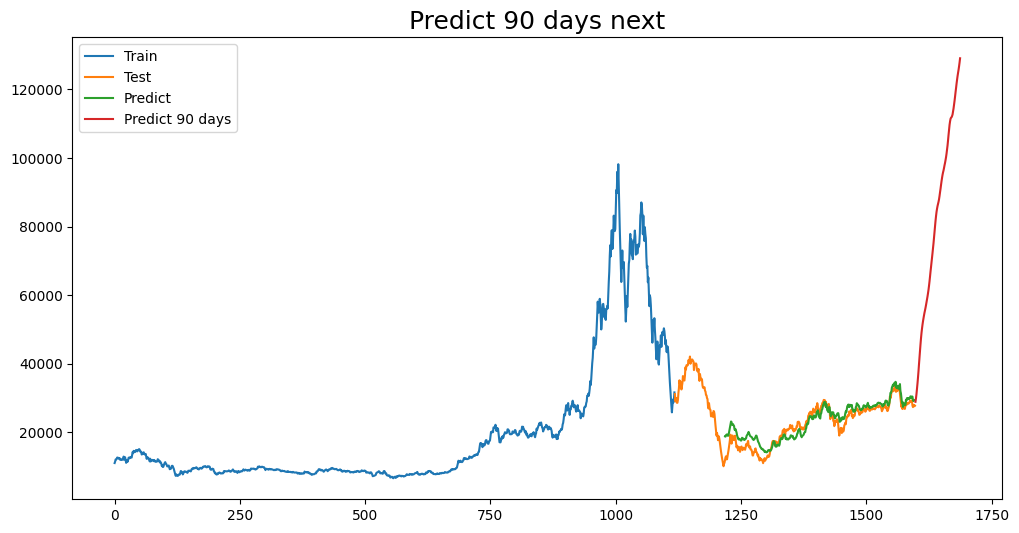

In [23]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

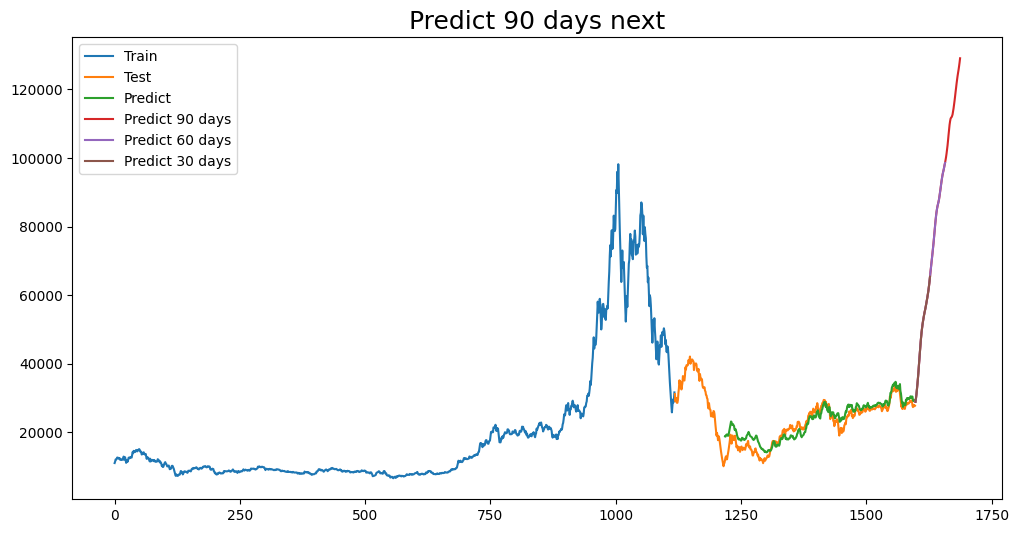

In [24]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')


future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

# Mô hình ResnetLSTM

In [25]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=50, num_lstm_layers=1):
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [26]:
# Khởi tạo mô hình
model2 = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [27]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model2(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.035475775599479675, Test Loss: 0.01927697875847419
Epoch 2/100, Loss: 0.011766771785914898, Test Loss: 0.009333515694985786
Epoch 3/100, Loss: 0.009512354619801044, Test Loss: 0.004743020127837856
Epoch 4/100, Loss: 0.001169777475297451, Test Loss: 0.0005556091346079484
Epoch 5/100, Loss: 0.0012436845572665334, Test Loss: 0.0005251662029574314
Epoch 6/100, Loss: 0.00038737402064725757, Test Loss: 0.00032229356778164703
Epoch 7/100, Loss: 0.00042458955431357026, Test Loss: 0.0002669847817742266
Epoch 8/100, Loss: 0.0002546325558796525, Test Loss: 0.00016164353534501666
Epoch 9/100, Loss: 0.0001774563716026023, Test Loss: 0.0001459726239166533
Epoch 10/100, Loss: 0.00019471350242383778, Test Loss: 0.00011476408872113097
Epoch 11/100, Loss: 0.00014446250861510634, Test Loss: 0.00013170972548929663
Epoch 12/100, Loss: 0.0001625585719011724, Test Loss: 0.0002106046692157785
Epoch 13/100, Loss: 0.0001471816940465942, Test Loss: 0.00015242569861584343
Epoch 14/100, Loss: 

In [28]:
# Dự báo dữ liệu test
model2.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model2(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model2(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [29]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 653.5566
Test MAPE: 3.1213%
Test MASE: 91970.2567
Test MSE: 755117.1502
Test RMSE: 868.9748


In [30]:
# Dự báo 90 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

In [31]:
# Dự báo 60 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [32]:
# Dự báo 30 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_30 = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_30.extend(yhat.detach().numpy().tolist())

lst_output_30 = scaler.inverse_transform(lst_output_30)

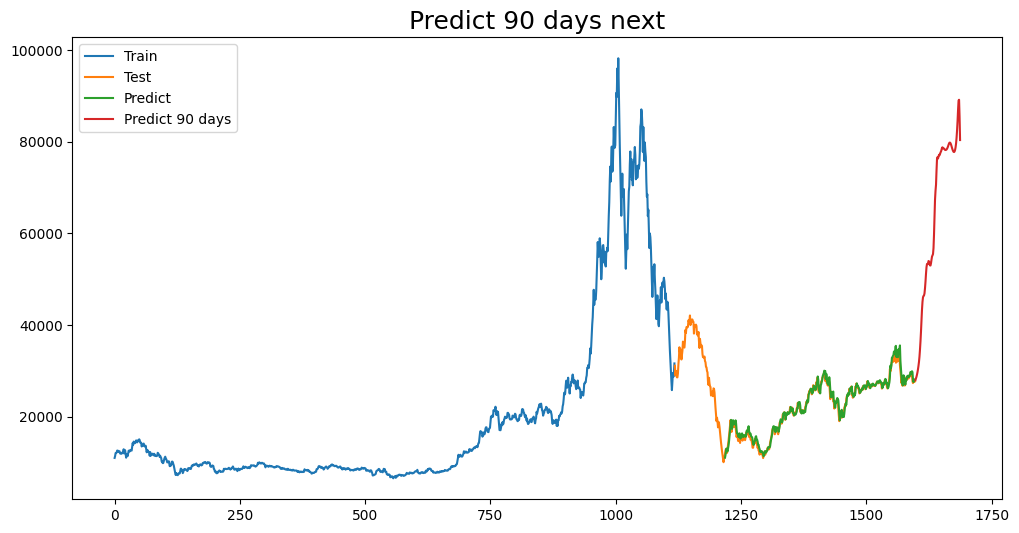

In [33]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

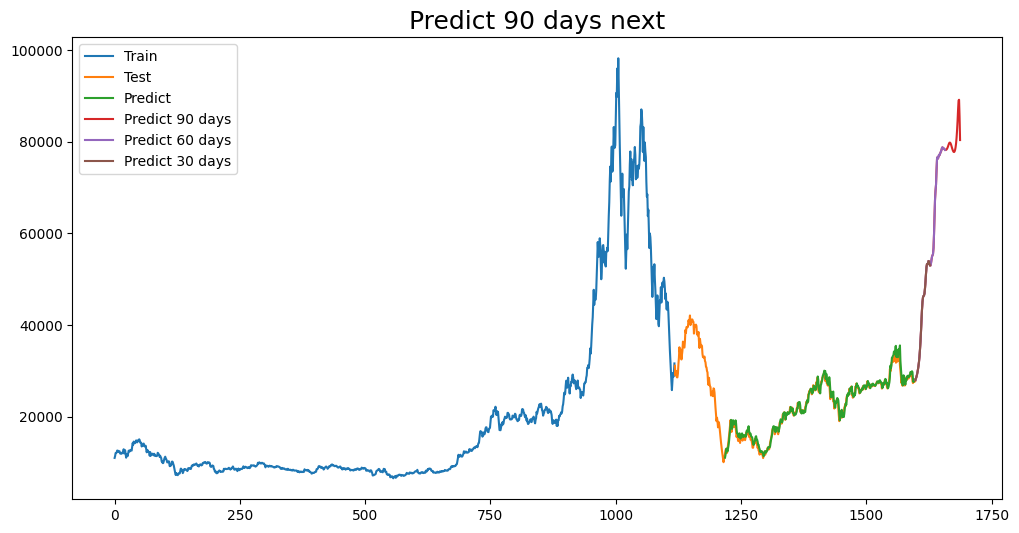

In [34]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')


future_data_index30 = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index30, lst_output_30, label='Predict 30 days')

plt.legend()
plt.show()